<a href="https://colab.research.google.com/github/bavanya/covid-19_tracker_data_mining/blob/master/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
import torch
import torch.nn as nn

import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
import pandas as pd
import io
import os
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from google.colab import files
uploaded = files.upload()

Saving csvData.csv to csvData.csv


,date,confirmed,deaths,recovered
0,2020-1-22,0,0,0
1,2020-1-23,0,0,0
2,2020-1-24,0,0,0
3,2020-1-25,0,0,0
4,2020-1-26,0,0,0
...,...,...,...,...
217,2020-8-26,3310234,60472,2523771
218,2020-8-27,3387500,61529,2583948
219,2020-8-28,3463972,62550,2648998
220,2020-8-29,3542733,63498,2713933


In [37]:
df = pd.read_csv(io.BytesIO(uploaded['csvData.csv']),  error_bad_lines = False) 
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df.index
print(df)

            confirmed  deaths  recovered
date                                    
2020-01-22          0       0          0
2020-01-23          0       0          0
2020-01-24          0       0          0
2020-01-25          0       0          0
2020-01-26          0       0          0
...               ...     ...        ...
2020-08-26    3310234   60472    2523771
2020-08-27    3387500   61529    2583948
2020-08-28    3463972   62550    2648998
2020-08-29    3542733   63498    2713933
2020-08-30    3621245   64469    2774801

[222 rows x 3 columns]


In [69]:
df1 = df[['confirmed']]
df1 = df1.diff()
df1.loc['2020-01-22', 'confirmed'] = 0
df1['confirmed'] = df1['confirmed'].astype(np.int64)
print(df1.head(15))
df1.dtypes

            confirmed
date                 
2020-01-22          0
2020-01-23          0
2020-01-24          0
2020-01-25          0
2020-01-26          0
2020-01-27          0
2020-01-28          0
2020-01-29          0
2020-01-30          1
2020-01-31          0
2020-02-01          0
2020-02-02          1
2020-02-03          1
2020-02-04          0
2020-02-05          0


confirmed    int64
dtype: object

In [39]:
all_data = df1['confirmed'].values.astype(float)
print(all_data)

[0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00
 1.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 2.0000e+00 0.0000e+00
 2.3000e+01 2.0000e+00 1.0000e+00 3.0000e+00 5.0000e+00 4.0000e+00
 1.3000e+01 6.0000e+00 1.1000e+01 9.0000e+00 2.0000e+01 1.1000e+01
 6.0000e+00 2.3000e+01 1.4000e+01 3.8000e+01 5.0000e+01 8.6000e+01
 6.6000e+01 1.0300e+02 3.7000e+01 1.2100e+02 7.0000e+01 1.6000e+02
 1.0000e+02 3.7000e+01 2.2700e+02 1.4600e+02 6.0100e+02 5.4500e+02
 2.4000e+01 5.1500e+02 5.0600e+02 1.1900e+03 5.3300e+02 6.0500e+02
 8.0900e+02 8.7300e+02 8.4800e+02 7.5900e+02 1.2480e+03 1.0340e+03
 8.3500e+02 1.1080e+03 9.2200e+02 1.3700e+03 1.8930e+03 9.2400

In [40]:
test_data_size = 15

train_data = all_data[:-test_data_size]
test_data = all_data[-test_data_size:]

In [41]:
print(len(train_data))
print(len(test_data))

207
15


In [42]:
print(test_data)

[57711. 55018. 64572. 69672. 68900. 69876. 69239. 61408. 60975. 57224.
 85687. 77266. 76472. 78761. 78512.]


In [43]:
scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data .reshape(-1, 1))

In [44]:
print(train_data_normalized[:5])
print(train_data_normalized[-5:])

[[-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]]
[[0.81981821]
 [1.        ]
 [0.92698398]
 [0.93232735]
 [0.91137181]]


In [45]:
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)

In [46]:
train_window = 12

In [47]:
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

In [48]:
train_inout_seq = create_inout_sequences(train_data_normalized, train_window)

In [49]:
train_inout_seq[:5]

[(tensor([-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000]), tensor([-1.0000])),
 (tensor([-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000]),
  tensor([-1.])),
 (tensor([-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000]), tensor([-1.])),
 (tensor([-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000]), tensor([-1.])),
 (tensor([-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000]), tensor([-1.]))]

In [50]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [51]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [52]:
print(model)

LSTM(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)


In [53]:
epochs = 150

for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   1 loss: 0.00215438
epoch:  26 loss: 0.00213052
epoch:  51 loss: 0.00031520
epoch:  76 loss: 0.00039292
epoch: 101 loss: 0.00514203
epoch: 126 loss: 0.00219089
epoch: 149 loss: 0.0019415875


In [54]:
fut_pred = 15

test_inputs = train_data_normalized[-train_window:].tolist()
print(test_inputs)

[0.5674562454223633, 0.680084764957428, 0.8668338060379028, 0.836952805519104, 0.922386884689331, 0.8526843786239624, 0.6000537276268005, 0.8198181986808777, 1.0, 0.9269840121269226, 0.9323273301124573, 0.9113718271255493]


In [55]:
model.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())

In [56]:
test_inputs[fut_pred:]

[1.0938702821731567,
 1.1211577653884888,
 1.1136804819107056,
 1.0186973810195923,
 0.9702460765838623,
 1.0258146524429321,
 1.0696436166763306,
 1.1118220090866089,
 1.1327271461486816,
 1.100357174873352,
 1.0223709344863892,
 0.9865392446517944]

In [57]:
actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:] ).reshape(-1, 1))
print(actual_predictions)

[[64614.20255667]
 [64107.11007965]
 [67977.58732653]
 [70143.60751766]
 [71057.72456163]
 [70807.23930377]
 [67625.35291547]
 [66002.25844252]
 [67863.77794951]
 [69332.02633685]
 [70744.9813934 ]
 [71445.29303241]
 [70360.91517967]
 [67748.41511983]
 [66548.07142621]]


In [95]:
x = np.arange(207, 222, 1)
print(x)

[207 208 209 210 211 212 213 214 215 216 217 218 219 220 221]


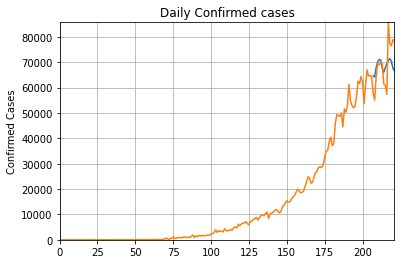

In [96]:
plt.title('Daily Confirmed cases')
plt.ylabel('Confirmed Cases')
plt.grid(True)
plt.autoscale(tight=True)
plt.plot(x, actual_predictions)
plt.plot(all_data)
plt.show()

In [98]:
#Mean squared error
def mape(y1, y_pred): 
    y1, y_pred = np.array(y1), np.array(y_pred)
    #return np.mean(np.abs((y1 - y_pred) / y1)) * 100
    return np.square(np.subtract(y1, y_pred)).mean()

In [108]:
print('\nMean squared error: %f'%mape(df1['confirmed'][207:],actual_predictions))
def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res


Mean squared error: 84827549.264449


In [109]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred)))) * 100

In [110]:
print('\nMean absolute percentage error: %f'%mean_absolute_percentage_error(df1['confirmed'][207:],actual_predictions))


Mean absolute percentage error: 9.556614
